In [1]:
import pandas as pd
import json
import boto3
import pathlib
import io
import sagemaker


from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer

from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import (
    ProcessingInput, 
    ProcessingOutput, 
    ScriptProcessor
)
from sagemaker.inputs import TrainingInput

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import (
    ProcessingStep, 
    TrainingStep, 
    CreateModelStep
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterFloat, 
    ParameterString, 
    ParameterBoolean
)
from sagemaker.workflow.clarify_check_step import (
    ModelBiasCheckConfig, 
    ClarifyCheckStep, 
    ModelExplainabilityCheckConfig
)
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.lambda_helper import Lambda

from sagemaker.model_metrics import (
    MetricsSource, 
    ModelMetrics, 
    FileSource
)
from sagemaker.drift_check_baselines import DriftCheckBaselines

from sagemaker.image_uris import retrieve

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Instantiate AWS services session and client objects
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "fraud-detect-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
sm_runtime_client = boto3.client("sagemaker-runtime")

# Fetch SageMaker execution role
sagemaker_role = sagemaker.get_execution_role()


# S3 locations used for parameterizing the notebook run
read_bucket = "sagemaker-sample-files"
read_prefix = "datasets/tabular/synthetic_automobile_claims" 

# S3 location where raw data to be fetched from
raw_data_key = f"s3://{read_bucket}/{read_prefix}"

# S3 location where processed data to be uploaded
processed_data_key = f"{write_prefix}/processed"

# S3 location where train data to be uploaded
train_data_key = f"{write_prefix}/train"

# S3 location where validation data to be uploaded
validation_data_key = f"{write_prefix}/validation"

# S3 location where test data to be uploaded
test_data_key = f"{write_prefix}/test"


# Full S3 paths
claims_data_uri = f"{raw_data_key}/claims.csv"
customers_data_uri = f"{raw_data_key}/customers.csv"
output_data_uri = f"s3://{write_bucket}/{write_prefix}/"
scripts_uri = f"s3://{write_bucket}/{write_prefix}/scripts"
estimator_output_uri = f"s3://{write_bucket}/{write_prefix}/training_jobs"
processing_output_uri = f"s3://{write_bucket}/{write_prefix}/processing_jobs"
model_eval_output_uri = f"s3://{write_bucket}/{write_prefix}/model_eval"
clarify_bias_config_output_uri = f"s3://{write_bucket}/{write_prefix}/model_monitor/bias_config"
clarify_explainability_config_output_uri = f"s3://{write_bucket}/{write_prefix}/model_monitor/explainability_config"
bias_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify_output/pipeline/bias"
explainability_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify_output/pipeline/explainability"

# Retrieve training image
training_image = retrieve(framework="xgboost", region=region, version="1.3-1")

[04/08/25 20:46:03] INFO     Ignoring unnecessary instance type: None.                            ]8;id=204437;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=411087;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [3]:
# Set names of pipeline objects
pipeline_name = "FraudDetectXGBPipeline"
pipeline_model_name = "fraud-detect-xgb-pipeline"
model_package_group_name = "fraud-detect-xgb-model-group"
base_job_name_prefix = "fraud-detect"
endpoint_config_name = f"{pipeline_model_name}-endpoint-config"
endpoint_name = f"{pipeline_model_name}-endpoint"

# Set data parameters
target_col = "fraud"

# Set instance types and counts
process_instance_type = "ml.c5.xlarge"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.m4.xlarge"
clarify_instance_count = 1
clarify_instance_type = "ml.m4.xlarge"

In [4]:
# Set up pipeline input parameters

# Set processing instance type
process_instance_type_param = ParameterString(
    name="ProcessingInstanceType",
    default_value=process_instance_type,
)

# Set training instance type
train_instance_type_param = ParameterString(
    name="TrainingInstanceType",
    default_value=train_instance_type,
)

# Set training instance count
train_instance_count_param = ParameterInteger(
    name="TrainingInstanceCount",
    default_value=train_instance_count
)

# Set deployment instance type
deploy_instance_type_param = ParameterString(
    name="DeployInstanceType",
    default_value=predictor_instance_type,
)

# Set deployment instance count
deploy_instance_count_param = ParameterInteger(
    name="DeployInstanceCount",
    default_value=predictor_instance_count
)

# Set Clarify check instance type
clarify_instance_type_param = ParameterString(
    name="ClarifyInstanceType",
    default_value=clarify_instance_type,
)

# Set model bias check params
skip_check_model_bias_param = ParameterBoolean(
    name="SkipModelBiasCheck", 
    default_value=False
)

register_new_baseline_model_bias_param = ParameterBoolean(
    name="RegisterNewModelBiasBaseline",
    default_value=False
)

supplied_baseline_constraints_model_bias_param = ParameterString(
    name="ModelBiasSuppliedBaselineConstraints", 
    default_value=""
)

# Set model explainability check params
skip_check_model_explainability_param = ParameterBoolean(
    name="SkipModelExplainabilityCheck", 
    default_value=False
)

register_new_baseline_model_explainability_param = ParameterBoolean(
    name="RegisterNewModelExplainabilityBaseline",
    default_value=False
)

supplied_baseline_constraints_model_explainability_param = ParameterString(
    name="ModelExplainabilitySuppliedBaselineConstraints", 
    default_value=""
)

# Set model approval param
model_approval_status_param = ParameterString(
    name="ModelApprovalStatus", default_value="Approved"
)

# Pipeline Flow

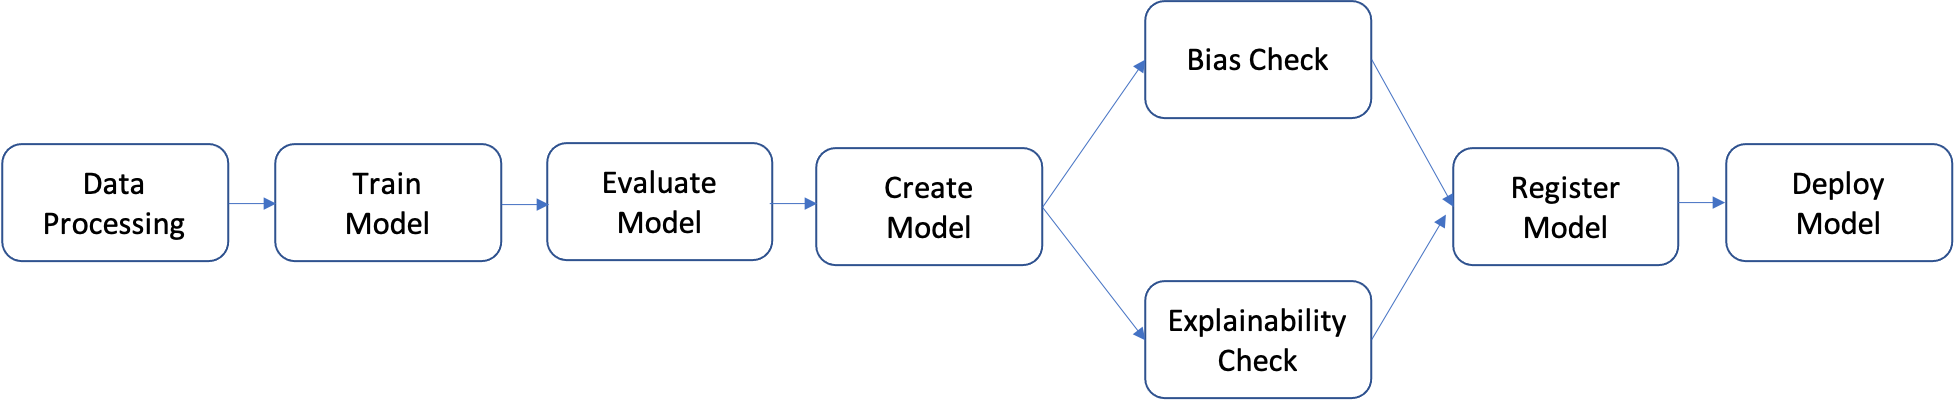

In [5]:
%%writefile preprocessing.py

import argparse
import pathlib
import boto3
import os
import pandas as pd
import logging
from sklearn.model_selection import train_test_split

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-ratio", type=float, default=0.8)
    parser.add_argument("--validation-ratio", type=float, default=0.1)
    parser.add_argument("--test-ratio", type=float, default=0.1)
    args, _ = parser.parse_known_args()
    logger.info("Received arguments {}".format(args))
    
    # Set local path prefix in the processing container
    local_dir = "/opt/ml/processing"    
    
    input_data_path_claims = os.path.join("/opt/ml/processing/claims", "claims.csv")
    input_data_path_customers = os.path.join("/opt/ml/processing/customers", "customers.csv")
    
    logger.info("Reading claims data from {}".format(input_data_path_claims))
    df_claims = pd.read_csv(input_data_path_claims)
    
    logger.info("Reading customers data from {}".format(input_data_path_customers))
    df_customers = pd.read_csv(input_data_path_customers)
    
    logger.debug("Formatting column names.")
    # Format column names
    df_claims = df_claims.rename({c : c.lower().strip().replace(' ', '_') for c in df_claims.columns}, axis = 1)
    df_customers = df_customers.rename({c : c.lower().strip().replace(' ', '_') for c in df_customers.columns}, axis = 1)
    
    logger.debug("Joining datasets.")
    # Join datasets
    df_data = df_claims.merge(df_customers, on = 'policy_id', how = 'left')

    # Drop selected columns not required for model building
    df_data = df_data.drop(['customer_zip'], axis = 1)
    
    # Select Ordinal columns
    ordinal_cols = ["police_report_available", "policy_liability", "customer_education"]

    # Select categorical columns and filling with na
    cat_cols_all = list(df_data.select_dtypes('object').columns)
    cat_cols = [c for c in cat_cols_all if c not in ordinal_cols]
    df_data[cat_cols] = df_data[cat_cols].fillna('na')
    
    logger.debug("One-hot encoding categorical columns.")
    # One-hot encoding categorical columns
    df_data = pd.get_dummies(df_data, columns = cat_cols)
    
    logger.debug("Encoding ordinal columns.")
    # Ordinal encoding
    mapping = {
               "Yes": "1",
               "No": "0" 
              }
    df_data['police_report_available'] = df_data['police_report_available'].map(mapping)
    df_data['police_report_available'] = df_data['police_report_available'].astype(float)

    mapping = {
               "15/30": "0",
               "25/50": "1", 
               "30/60": "2",
               "100/200": "3"
              }
    
    df_data['policy_liability'] = df_data['policy_liability'].map(mapping)
    df_data['policy_liability'] = df_data['policy_liability'].astype(float)

    mapping = {
               "Below High School": "0",
               "High School": "1", 
               "Associate": "2",
               "Bachelor": "3",
               "Advanced Degree": "4"
              }
    
    df_data['customer_education'] = df_data['customer_education'].map(mapping)
    df_data['customer_education'] = df_data['customer_education'].astype(float)
    
    df_processed = df_data.copy()
    df_processed.columns = [c.lower() for c in df_data.columns]
    df_processed = df_processed.drop(["policy_id", "customer_gender_unkown"], axis=1)
    
    # Split into train, validation, and test sets
    train_ratio = args.train_ratio
    val_ratio = args.validation_ratio
    test_ratio = args.test_ratio
    
    logger.debug("Splitting data into train, validation, and test sets")
    
    y = df_processed['fraud']
    X = df_processed.drop(['fraud'], axis = 1)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio, random_state=42)

    train_df = pd.concat([y_train, X_train], axis = 1)
    val_df = pd.concat([y_val, X_val], axis = 1)
    test_df = pd.concat([y_test, X_test], axis = 1)
    dataset_df = pd.concat([y, X], axis = 1)
    
    logger.info("Train data shape after preprocessing: {}".format(train_df.shape))
    logger.info("Validation data shape after preprocessing: {}".format(val_df.shape))
    logger.info("Test data shape after preprocessing: {}".format(test_df.shape))
    
    # Save processed datasets to the local paths in the processing container.
    # SageMaker will upload the contents of these paths to S3 bucket
    logger.debug("Writing processed datasets to container local path.")
    train_output_path = os.path.join(f"{local_dir}/train", "train.csv")
    validation_output_path = os.path.join(f"{local_dir}/val", "validation.csv")
    test_output_path = os.path.join(f"{local_dir}/test", "test.csv")
    full_processed_output_path = os.path.join(f"{local_dir}/full", "dataset.csv")

    logger.info("Saving train data to {}".format(train_output_path))
    train_df.to_csv(train_output_path, index=False)
    
    logger.info("Saving validation data to {}".format(validation_output_path))
    val_df.to_csv(validation_output_path, index=False)

    logger.info("Saving test data to {}".format(test_output_path))
    test_df.to_csv(test_output_path, index=False)
    
    logger.info("Saving full processed data to {}".format(full_processed_output_path))
    dataset_df.to_csv(full_processed_output_path, index=False)


Overwriting preprocessing.py


In [6]:
from sagemaker.workflow.pipeline_context import PipelineSession
# Upload processing script to S3
s3_client.upload_file(
    Filename="preprocessing.py", Bucket=write_bucket, Key=f"{write_prefix}/scripts/preprocessing.py"
)

# Define the SKLearnProcessor configuration
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker_role,
    instance_count=1,
    instance_type=process_instance_type,
    base_job_name=f"{base_job_name_prefix}-processing",
)

# Define pipeline processing step
process_step = ProcessingStep(
    name="DataProcessing",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=claims_data_uri, destination="/opt/ml/processing/claims"),
        ProcessingInput(source=customers_data_uri, destination="/opt/ml/processing/customers")
    ],
    outputs=[
        ProcessingOutput(destination=f"{processing_output_uri}/train_data", output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(destination=f"{processing_output_uri}/validation_data", output_name="validation_data", source="/opt/ml/processing/val"),
        ProcessingOutput(destination=f"{processing_output_uri}/test_data", output_name="test_data", source="/opt/ml/processing/test"),
        ProcessingOutput(destination=f"{processing_output_uri}/processed_data", output_name="processed_data", source="/opt/ml/processing/full")
    ],
    job_arguments=[
        "--train-ratio", "0.8", 
        "--validation-ratio", "0.1",
        "--test-ratio", "0.1"
    ],
    code=f"s3://{write_bucket}/{write_prefix}/scripts/preprocessing.py"
)

                    INFO     Defaulting to only available Python version: py3                     ]8;id=119789;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=908203;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

In [7]:
%%writefile xgboost_train.py

import argparse
import os
import joblib
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters and algorithm parameters are described here
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--max_depth", type=int, default=3)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--subsample", type=float, default=0.9)
    parser.add_argument("--colsample_bytree", type=float, default=0.8)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--nfold", type=int, default=3)
    parser.add_argument("--early_stopping_rounds", type=int, default=3)
    

    # SageMaker specific arguments. Defaults are set in the environment variables
    # Set location of input training data
    parser.add_argument("--train_data_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    # Set location of input validation data
    parser.add_argument("--validation_data_dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    # Set location where trained model will be stored. Default set by SageMaker, /opt/ml/model
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    # Set location where model artifacts will be stored. Default set by SageMaker, /opt/ml/output/data
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    
    args = parser.parse_args()

    data_train = pd.read_csv(f"{args.train_data_dir}/train.csv")
    train = data_train.drop("fraud", axis=1)
    label_train = pd.DataFrame(data_train["fraud"])
    dtrain = xgb.DMatrix(train, label=label_train)
    
    
    data_validation = pd.read_csv(f"{args.validation_data_dir}/validation.csv")
    validation = data_validation.drop("fraud", axis=1)
    label_validation = pd.DataFrame(data_validation["fraud"])
    dvalidation = xgb.DMatrix(validation, label=label_validation)
    
    # Choose XGBoost model hyperparameters
    params = {"max_depth": args.max_depth,
              "eta": args.eta,
              "objective": args.objective,
              "subsample" : args.subsample,
              "colsample_bytree":args.colsample_bytree
             }
    
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds
    
    # Cross-validate train XGBoost model
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=["auc"],
        seed=42,
    )
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dvalidation)
    
    train_auc = roc_auc_score(label_train, train_pred)
    validation_auc = roc_auc_score(label_validation, validation_pred)
    
    print(f"[0]#011train-auc:{train_auc:.2f}")
    print(f"[0]#011validation-auc:{validation_auc:.2f}")

    metrics_data = {"hyperparameters" : params,
                    "binary_classification_metrics": {"validation:auc": {"value": validation_auc},
                                                      "train:auc": {"value": train_auc}
                                                     }
                   }
              
    # Save the evaluation metrics to the location specified by output_data_dir
    metrics_location = args.output_data_dir + "/metrics.json"
    
    # Save the trained model to the location specified by model_dir
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        joblib.dump(model, f)

Overwriting xgboost_train.py


In [8]:
# Set XGBoost model hyperparameters 
hyperparams = {
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "num_round": "5",
    "max_depth": "5",
    "subsample":"0.75",
    "colsample_bytree":"0.75",
    "eta":"0.5"
}

# Set XGBoost estimator
xgb_estimator = XGBoost(
    entry_point="xgboost_train.py", 
    output_path=estimator_output_uri,
    code_location=estimator_output_uri,
    hyperparameters=hyperparams,
    role=sagemaker_role,
    # Fetch instance type and count from pipeline parameters
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.3-1"
)

# Access the location where the preceding processing step saved train and validation datasets
# Pipeline step properties can give access to outputs which can be used in succeeding steps
s3_input_train = TrainingInput(
s3_data=process_step.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri, 
content_type="csv", 
s3_data_type="S3Prefix"
)
s3_input_validation = TrainingInput(
s3_data=process_step.properties.ProcessingOutputConfig.Outputs["validation_data"].S3Output.S3Uri,
content_type="csv",
s3_data_type="S3Prefix"
)

# Set pipeline training step"
train_step = TrainingStep(
    name="XGBModelTraining",
    estimator=xgb_estimator,
    inputs={
    "train":s3_input_train, # Train channel 
    "validation": s3_input_validation # Validation channel
}
)

                    INFO     Ignoring unnecessary Python version: py3.                            ]8;id=312607;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=90831;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.c4.2xlarge.                   ]8;id=615567;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=685627;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [9]:
# Create a SageMaker model
model = sagemaker.model.Model(
    image_uri=training_image,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sess,
    role=sagemaker_role
)

# Specify model deployment instance type
inputs = sagemaker.inputs.CreateModelInput(instance_type=deploy_instance_type_param)

create_model_step = CreateModelStep(name="FraudDetModel", model=model, inputs=inputs)

In [10]:
# Set up common configuration parameters to be used across multiple steps
check_job_config = CheckJobConfig(
    role=sagemaker_role,
    instance_count=1,
    instance_type=clarify_instance_type,
    volume_size_in_gb=30,
    sagemaker_session=sess,
)

# Set up configuration of data to be used for model bias check
model_bias_data_config = sagemaker.clarify.DataConfig(
    # Fetch S3 location where processing step saved train data
    s3_data_input_path=process_step.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri,
    s3_output_path=bias_report_output_uri,
    label=target_col,
    dataset_type="text/csv",
    s3_analysis_config_output_path=clarify_bias_config_output_uri
)

# Set up details of the trained model to be checked for bias
model_config = sagemaker.clarify.ModelConfig(
    # Pull model name from model creation step
    model_name=create_model_step.properties.ModelName,
    instance_count=train_instance_count,
    instance_type=train_instance_type
)

# Set up column and categories that are to be checked for bias
model_bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1]
)

# Set up model predictions configuration to get binary labels from probabilities
model_predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

model_bias_check_config = ModelBiasCheckConfig(
    data_config=model_bias_data_config,
    data_bias_config=model_bias_config,
    model_config=model_config,
    model_predicted_label_config=model_predictions_config,
    methods=["DPPL"]
)

# Set up pipeline model bias check step
model_bias_check_step = ClarifyCheckStep(
    name="ModelBiasCheck",
    clarify_check_config=model_bias_check_config,
    check_job_config=check_job_config,
    skip_check=skip_check_model_bias_param,
    register_new_baseline=register_new_baseline_model_bias_param,
    supplied_baseline_constraints=supplied_baseline_constraints_model_bias_param
)

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=701568;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=724139;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Uploading analysis config to {s3_uri}.                 ]8;id=903546;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model_monitor/clarify_model_monitoring.py\clarify_model_monitoring.py]8;;\:]8;id=434131;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model_monitor/clarify_model_monitoring.py#227\227]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=918799;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=796385;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [11]:
# Set configuration of data to be used for model explainability check
model_explainability_data_config = sagemaker.clarify.DataConfig(
    # Fetch S3 location where processing step saved train data
    s3_data_input_path=process_step.properties.ProcessingOutputConfig.Outputs["train_data"].S3Output.S3Uri,
    s3_output_path=explainability_report_output_uri,
    label=target_col,
    dataset_type="text/csv",
    s3_analysis_config_output_path=clarify_explainability_config_output_uri 
)

# Set SHAP configuration for Clarify to compute global and local SHAP values for feature importance
shap_config = sagemaker.clarify.SHAPConfig(
    seed=42, 
    num_samples=100,
    agg_method="mean_abs",
    save_local_shap_values=True
)

model_explainability_config = ModelExplainabilityCheckConfig(
    data_config=model_explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config
)

# Set pipeline model explainability check step
model_explainability_step = ClarifyCheckStep(
    name="ModelExplainabilityCheck",
    clarify_check_config=model_explainability_config,
    check_job_config=check_job_config,
    skip_check=skip_check_model_explainability_param,
    register_new_baseline=register_new_baseline_model_explainability_param,
    supplied_baseline_constraints=supplied_baseline_constraints_model_explainability_param
)

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=734477;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=25966;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Uploading analysis config to {s3_uri}.                 ]8;id=972684;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model_monitor/clarify_model_monitoring.py\clarify_model_monitoring.py]8;;\:]8;id=741192;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model_monitor/clarify_model_monitoring.py#227\227]8;;\

[04/08/25 20:46:04] INFO     Ignoring unnecessary instance type: None.                            ]8;id=367975;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=360869;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [12]:
%%writefile evaluate.py

import json
import logging
import pathlib
import pickle
import tarfile

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


if __name__ == "__main__":
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    logger.debug("Loading xgboost model.")
    # The name of the file should match how the model was saved in the training script
    model = pickle.load(open("xgboost-model", "rb"))

    logger.debug("Reading test data.")
    test_local_path = "/opt/ml/processing/test/test.csv"
    df_test = pd.read_csv(test_local_path)
    
    # Extract test set target column
    y_test = df_test.iloc[:, 0].values
   
    cols_when_train = model.feature_names
    # Extract test set feature columns
    X = df_test[cols_when_train].copy()
    X_test = xgb.DMatrix(X)

    logger.info("Generating predictions for test data.")
    pred = model.predict(X_test)
    
    # Calculate model evaluation score
    logger.debug("Calculating ROC-AUC score.")
    auc = roc_auc_score(y_test, pred)
    metric_dict = {
        "classification_metrics": {"roc_auc": {"value": auc}}
    }
    
    # Save model evaluation metrics
    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    logger.info("Writing evaluation report with ROC-AUC: %f", auc)
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(metric_dict))

Overwriting evaluate.py


In [13]:
# Upload model evaluation script to S3
s3_client.upload_file(
    Filename="evaluate.py", Bucket=write_bucket, Key=f"{write_prefix}/scripts/evaluate.py"
)

eval_processor = ScriptProcessor(
    image_uri=training_image,
    command=["python3"],
    instance_type=predictor_instance_type,
    instance_count=predictor_instance_count,
    base_job_name=f"{base_job_name_prefix}-model-eval",
    sagemaker_session=sess,
    role=sagemaker_role,
)
evaluation_report = PropertyFile(
    name="FraudDetEvaluationReport",
    output_name="evaluation",
    path="evaluation.json",
)

# Set model evaluation step
evaluation_step = ProcessingStep(
    name="XGBModelEvaluate",
    processor=eval_processor,
    inputs=[
        ProcessingInput(
            # Fetch S3 location where train step saved model artifacts
            source=train_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            # Fetch S3 location where processing step saved test data
            source=process_step.properties.ProcessingOutputConfig.Outputs["test_data"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(destination=f"{model_eval_output_uri}", output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code=f"s3://{write_bucket}/{write_prefix}/scripts/evaluate.py",
    property_files=[evaluation_report],
)

In [14]:
# Fetch baseline constraints to record in model registry
model_metrics = ModelMetrics(
    bias_post_training=MetricsSource(
        s3_uri=model_bias_check_step.properties.CalculatedBaselineConstraints,
        content_type="application/json"
    ),
    explainability=MetricsSource(
        s3_uri=model_explainability_step.properties.CalculatedBaselineConstraints,
        content_type="application/json"
    ),
)

# Fetch baselines to record in model registry for drift check
drift_check_baselines = DriftCheckBaselines(
    bias_post_training_constraints=MetricsSource(
        s3_uri=model_bias_check_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    explainability_constraints=MetricsSource(
        s3_uri=model_explainability_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    explainability_config_file=FileSource(
        s3_uri=model_explainability_config.monitoring_analysis_config_uri,
        content_type="application/json",
    ),
)

# Define register model step
register_step = RegisterModel(
    name="XGBRegisterModel",
    estimator=xgb_estimator,
    # Fetching S3 location where train step saved model artifacts
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=[predictor_instance_type],
    transform_instances=[predictor_instance_type],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status_param,
    # Registering baselines metrics that can be used for model monitoring
    model_metrics=model_metrics,
    drift_check_baselines=drift_check_baselines
)

In [15]:
%%writefile lambda_deployer.py

"""
Lambda function creates an endpoint configuration and deploys a model to real-time endpoint. 
Required parameters for deployment are retrieved from the event object
"""

import json
import boto3


def lambda_handler(event, context):
    sm_client = boto3.client("sagemaker")

    # Details of the model created in the Pipeline CreateModelStep
    model_name = event["model_name"]
    model_package_arn = event["model_package_arn"]
    endpoint_config_name = event["endpoint_config_name"]
    endpoint_name = event["endpoint_name"]
    role = event["role"]
    instance_type = event["instance_type"]
    instance_count = event["instance_count"]
    primary_container = {"ModelPackageName": model_package_arn}

    # Create model
    model = sm_client.create_model(
        ModelName=model_name,
        PrimaryContainer=primary_container,
        ExecutionRoleArn=role
    )

    # Create endpoint configuration
    create_endpoint_config_response = sm_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
        {
            "VariantName": "Alltraffic",
            "ModelName": model_name,
            "InitialInstanceCount": instance_count,
            "InstanceType": instance_type,
            "InitialVariantWeight": 1
        }
        ]
    )

    # Create endpoint
    create_endpoint_response = sm_client.create_endpoint(
        EndpointName=endpoint_name, 
        EndpointConfigName=endpoint_config_name
    )

Overwriting lambda_deployer.py


In [16]:
# The function name must contain sagemaker
function_name = "sagemaker-fraud-det-demo-lambda-step"
# Define Lambda helper class can be used to create the Lambda function required in the Lambda step
func = Lambda(
    function_name=function_name,
    execution_role_arn=sagemaker_role,
    script="lambda_deployer.py",
    handler="lambda_deployer.lambda_handler",
    timeout=600,
    memory_size=3008,
)

# The inputs used in the lambda handler are passed through the inputs argument in the 
# LambdaStep and retrieved via the `event` object within the `lambda_handler` function

lambda_deploy_step = LambdaStep(
    name="LambdaStepRealTimeDeploy",
    lambda_func=func,
    inputs={
        "model_name": pipeline_model_name,
        "endpoint_config_name": endpoint_config_name,
        "endpoint_name": endpoint_name,
        "model_package_arn": register_step.steps[0].properties.ModelPackageArn,
        "role": sagemaker_role,
        "instance_type": deploy_instance_type_param,
        "instance_count": deploy_instance_count_param
    }
)

In [17]:
# Evaluate model performance on test set
cond_gte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file=evaluation_report,
        json_path="classification_metrics.roc_auc.value",
    ),
    right=0.7, # Threshold to compare model performance against
)
condition_step = ConditionStep(
    name="CheckFraudDetXGBEvaluation",
    conditions=[cond_gte],
    if_steps=[create_model_step, model_bias_check_step, model_explainability_step, register_step, lambda_deploy_step], 
    else_steps=[]
)

In [18]:
# Create the Pipeline with all component steps and parameters
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[process_instance_type_param, 
                train_instance_type_param, 
                train_instance_count_param, 
                deploy_instance_type_param,
                deploy_instance_count_param,
                clarify_instance_type_param,
                skip_check_model_bias_param,
                register_new_baseline_model_bias_param,
                supplied_baseline_constraints_model_bias_param,
                skip_check_model_explainability_param,
                register_new_baseline_model_explainability_param,
                supplied_baseline_constraints_model_explainability_param,
                model_approval_status_param],
    steps=[
        process_step,
        train_step,
        evaluation_step,
        condition_step
    ],
    sagemaker_session=sess
    
)

In [19]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=sagemaker_role)

# Full Pipeline description
pipeline_definition = json.loads(pipeline.describe()['PipelineDefinition'])
pipeline_definition

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=603348;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=367247;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=423432;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=882401;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=553314;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=672034;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelName' from the pipeline definition by default since ]8;id=666917;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=163745;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             it will be overridden at pipeline execution time. Please utilize the                  
                             PipelineDefinitionConfig to persist this field in the pipeline                        
                             definition if desired.                                                                

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=413007;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=140628;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=246921;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=319220;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  No finished training job found associated with this estimator.       ]8;id=733569;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=266713;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=972902;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=356961;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=810282;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=497472;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

[04/08/25 20:46:05] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=774709;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=146675;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=798014;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=364225;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=693003;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=254416;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelName' from the pipeline definition by default since ]8;id=63045;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=418760;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             it will be overridden at pipeline execution time. Please utilize the                  
                             PipelineDefinitionConfig to persist this field in the pipeline                        
                             definition if desired.                                                                

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=766946;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=893612;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=226740;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=585853;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  No finished training job found associated with this estimator.       ]8;id=168062;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=391736;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=689006;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=247015;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=755856;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=167638;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c4.2xlarge'},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c4.2xlarge'},
  {'Name': 'TrainingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'DeployInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c4.2xlarge'},
  {'Name': 'DeployInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'ClarifyInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.c4.2xlarge'},
  {'Name': 'SkipModelBiasCheck', 'Type': 'Boolean', 'DefaultValue': False},
  {'Name': 'RegisterNewModelBiasBaseline',
   'Type': 'Boolean',
   'DefaultValue': False},
  {'Name': 'ModelBiasSuppliedBaselineConstraints',
   'Type': 'String',
   'DefaultValue': ''},
  {'Name': 'SkipModelExplainabilityCheck',
   'Type': 'Boolean',
   'DefaultValue': False},
  {'Name': 'RegisterNewModelExplainabilityBaseline',
   'Type': 'Boo

In [21]:
# Fetch test data to run predictions with the endpoint
test_df = pd.read_csv(f"{processing_output_uri}/test_data/test.csv", low_memory=False)

# Create SageMaker Predictor from the deployed endpoint
predictor = sagemaker.predictor.Predictor(endpoint_name, 
                                          sagemaker_session=sess,
                                          serializer=CSVSerializer(),
                                          deserializer=CSVDeserializer()
                                         )
# Test endpoint with payload of 5 samples
payload = test_df.drop(["fraud"], axis=1).iloc[:5]
result = predictor.predict(payload.values)
prediction_df = pd.DataFrame()
prediction_df["Prediction"] = result
prediction_df["Label"] = test_df["fraud"].iloc[:5].values
prediction_df

,Prediction,Label
0,[0.1918722540140152],0
1,[0.06236206740140915],0
2,[0.04445870965719223],0
3,[0.08237560093402863],0
4,[0.06236206740140915],0


In [22]:
# Delete the Lambda function
func.delete()

# Delete the endpoint
sm_client.delete_endpoint(EndpointName=endpoint_name)

# Delete the EndpointConfig
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete the model
sm_client.delete_model(ModelName=pipeline_model_name)

# Delete the pipeline
sm_client.delete_pipeline(PipelineName=pipeline_name)

{'PipelineArn': 'arn:aws:sagemaker:ap-south-1:891377158261:pipeline/FraudDetectXGBPipeline',
 'ResponseMetadata': {'RequestId': 'a99f86cc-3ea4-4dc7-a66f-c54c2b4a81a5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a99f86cc-3ea4-4dc7-a66f-c54c2b4a81a5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '91',
   'date': 'Tue, 08 Apr 2025 20:47:01 GMT'},
  'RetryAttempts': 0}}